# Quora Insincere Question Detection

# Import Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stopwords = nltk.corpus.stopwords.words('english')
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

# Reading Data

In [2]:
train_data = pd.read_csv('../input/quora-insincere-questions-classification/train.csv')
train_data.head()

qid                                      question_text  \
0  00002165364db923c7e6  How did Quebec nationalists see their province...   
1  000032939017120e6e44  Do you have an adopted dog, how would you enco...   
2  0000412ca6e4628ce2cf  Why does velocity affect time? Does velocity a...   
3  000042bf85aa498cd78e  How did Otto von Guericke used the Magdeburg h...   
4  0000455dfa3e01eae3af  Can I convert montra helicon D to a mountain b...   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

# Data Description

In [3]:
print("Number of data points in train data", train_data.shape)
print('-'*70)
print("The attributes of data :", train_data.columns.values)

Number of data points in train data (1306122, 3)
----------------------------------------------------------------------
The attributes of data : ['qid' 'question_text' 'target']


### QID Column Description

In [4]:
len(train_data['qid'].unique())

1306122

Each row has a unique QID. So, it has no use in dataset. We drop it.

In [5]:
train_data.drop(['qid'], axis=1, inplace=True)

### NULL Value Check

In [6]:
train_data.isna().any()

question_text    False
target           False
dtype: bool

No null values are found in the dataset.

### Duplicate Value Check

In [7]:
train_data.duplicated().any()

False

No duplicate rows are found in the dataset.

# Data Analysis

### Class Distribution

Insincere Questions:  80810 , ( 6.187017751787352 %)
Sincere Questions:  1225312 , ( 93.81298224821265 %)


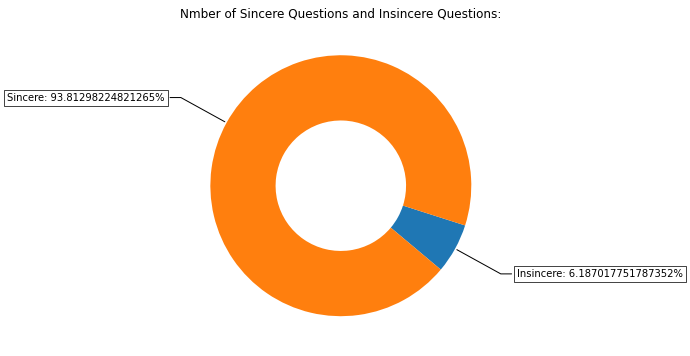

In [8]:
#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = train_data['target'].value_counts()
insincere = (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100
sincere = (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100
print("Insincere Questions: ", y_value_counts[1], ", (", insincere,"%)")
print("Sincere Questions: ", y_value_counts[0], ", (", sincere,"%)")
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Insincere: "+str(insincere)+"%", "Sincere: "+str(sincere)+"%"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of Sincere Questions and Insincere Questions:")

plt.show()

Out of 1306122 questions, 93.81% are sincere. So, data is imbalanced. This might affect classification metrics later on.

# Text Feature Preprocessing

### Tokenization

In [9]:
train_data['question_text'] = train_data['question_text'].str.split()

### Lowercase Text

In [10]:
train_data['question_text'] = train_data.apply(lambda row: [token.lower() for token in row['question_text']], axis=1)

In [11]:
def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

In [12]:
train_data['question_text'] = train_data.apply(lambda row: [remove_html(token) for token in row['question_text']] , 
                                          axis=1)
train_data['question_text'].head()

0    [how, did, quebec, nationalists, see, their, p...
1    [do, you, have, an, adopted, dog,, how, would,...
2    [why, does, velocity, affect, time?, does, vel...
3    [how, did, otto, von, guericke, used, the, mag...
4    [can, i, convert, montra, helicon, d, to, a, m...
Name: question_text, dtype: object

### Remove Non-Alphanumerics from Text

In [13]:
train_data['question_text'] = train_data.apply(lambda row: [re.sub(r'\W+', '', token) for token in row['question_text']], axis=1)

### Store Stopwords

In [14]:
train_data['stopwords'] = train_data.apply(lambda row: [token for token in row['question_text'] if token in stopwords], axis=1)

### Remove Stopwords

In [15]:
train_data['clean_text'] = train_data.apply(lambda row: [token for token in row['question_text'] if token not in stopwords], axis=1)

### Stem Cleaned Text

In [16]:
porter = PorterStemmer()
train_data['stemmed_text'] = train_data.apply(lambda row: [porter.stem(token) for token in row['clean_text']] , axis=1)

### Lemmatize Cleaned Text

In [17]:
wnl = WordNetLemmatizer()
train_data['lemmatized_text'] = train_data.apply(lambda row: [wnl.lemmatize(token) for token in row['clean_text']] , axis=1)

### Tokens to String

In [18]:
train_data['question_text'] = train_data['question_text'].apply(lambda row: " ".join(row))
train_data['clean_text'] = train_data['clean_text'].apply(lambda row: " ".join(row))
train_data['stopwords'] = train_data['stopwords'].apply(lambda row: " ".join(row))
train_data['stemmed_text'] = train_data['stemmed_text'].apply(lambda row: " ".join(row))
train_data['lemmatized_text'] = train_data['lemmatized_text'].apply(lambda row: " ".join(row))

In [19]:
train_data

question_text  target  \
0        how did quebec nationalists see their province...       0   
1        do you have an adopted dog how would you encou...       0   
2        why does velocity affect time does velocity af...       0   
3        how did otto von guericke used the magdeburg h...       0   
4        can i convert montra helicon d to a mountain b...       0   
...                                                    ...     ...   
1306117  what other technical skills do you need as a c...       0   
1306118  does ms in ece have good job prospects in usa ...       0   
1306119                           is foam insulation toxic       0   
1306120  how can one start a research project based on ...       0   
1306121  who wins in a battle between a wolverine and a...       0   

                                     stopwords  \
0                    how did their as a in the   
1            do you have an how you to and not   
2                                why does does   
3                                  how did the   
4                     can i d to a by just the   
...                                        ...   
1306117  what other do you as a other than and   
1306118   does in have in or there are more it   
1306119                                     is   
1306120                        how can a on at   
1306121               who in a between a and a   

                                                clean_text  \
0            quebec nationalists see province nation 1960s   
1            adopted dog would encourage people adopt shop   
2        velocity affect time velocity affect space geo...   
3             otto von guericke used magdeburg hemispheres   
4        convert montra helicon mountain bike changing ...   
...                                                    ...   
1306117  technical skills need computer science undergr...   
1306118  ms ece good job prospects usa like india jobs ...   
1306119                              foam insulation toxic   
1306120  one start research project based biochemistry ...   
1306121                         wins battle wolverine puma   

                                              stemmed_text  \
0               quebec nationalist see provinc nation 1960   
1                adopt dog would encourag peopl adopt shop   
2            veloc affect time veloc affect space geometri   
3                 otto von guerick use magdeburg hemispher   
4          convert montra helicon mountain bike chang tyre   
...                                                    ...   
1306117     technic skill need comput scienc undergrad c c   
1306118  ms ece good job prospect usa like india job pr...   
1306119                                   foam insul toxic   
1306120  one start research project base biochemistri u...   
1306121                            win battl wolverin puma   

                                           lemmatized_text  
0             quebec nationalist see province nation 1960s  
1            adopted dog would encourage people adopt shop  
2        velocity affect time velocity affect space geo...  
3              otto von guericke used magdeburg hemisphere  
4        convert montra helicon mountain bike changing ...  
...                                                    ...  
1306117  technical skill need computer science undergra...  
1306118  m ece good job prospect usa like india job pre...  
1306119                              foam insulation toxic  
1306120  one start research project based biochemistry ...  
1306121                          win battle wolverine puma  

[1306122 rows x 6 columns]

# Text Feature Analysis

# Univariate Analysis: Word count for Question Text (Without Stopword Removal)

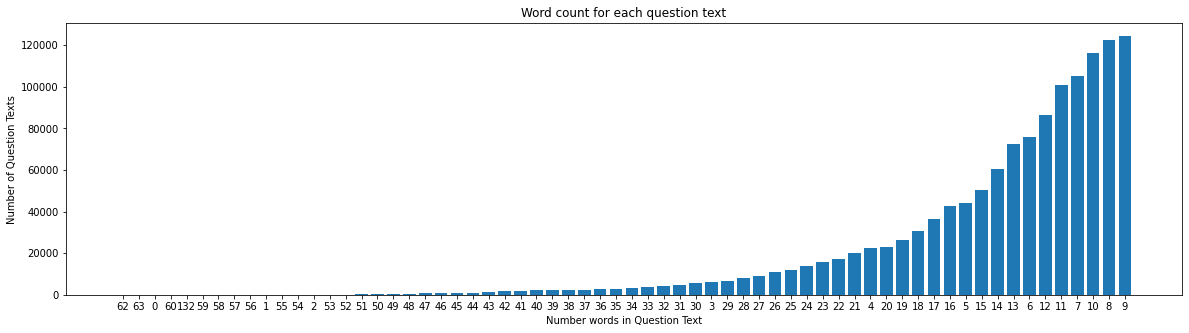

In [20]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = train_data['question_text'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Question Texts')
plt.xlabel('Number words in Question Text')
plt.title('Word count for each question text')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

**SUMMARY:Most of the question texts contain upto 25 words.**

# Univariate Analysis: Word count for Clean Text

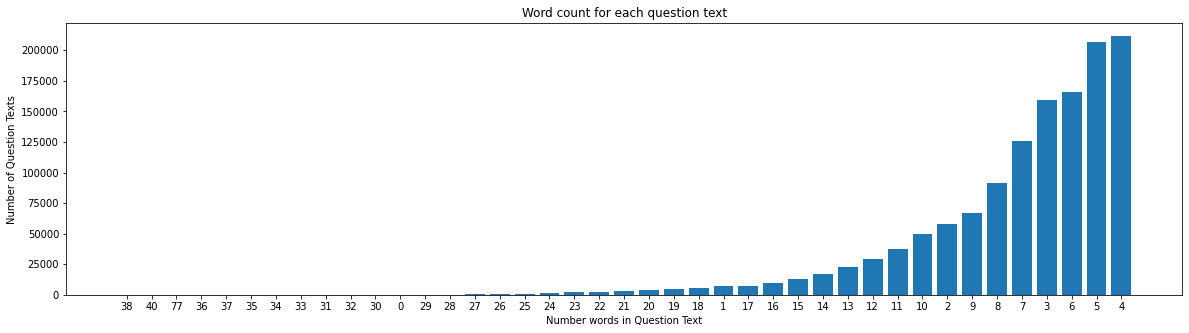

In [21]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = train_data['stemmed_text'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Question Texts')
plt.xlabel('Number words in Question Text')
plt.title('Word count for each question text')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

**SUMMARY:Most of the clean texts questions contain upto 15 words meaning 10 words at an average are stopwords.**

# Bivariate Analysis

## Classwise Distribution

### Question Text Distribution

#### PDF

In [22]:
insincere_words = train_data[train_data['target']==1]['question_text'].str.split().apply(len)
insincere_word_count = insincere_words.values

sincere_words = train_data[train_data['target']==0]['question_text'].str.split().apply(len)
sincere_word_count = sincere_words.values

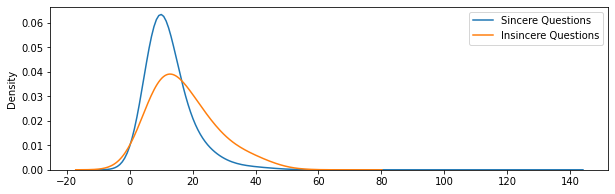

In [23]:
plt.figure(figsize=(10,3))
sns.kdeplot(sincere_word_count,label="Sincere Questions", bw=0.6)
sns.kdeplot(insincere_word_count,label="Insincere Questions", bw=0.6)
plt.legend()
plt.show()

**SUMMARY:The insincere questions have wider spread towards right meaning that sincere questions are upto the point and insincere might have lot of non-sense words in them.**

#### CDF

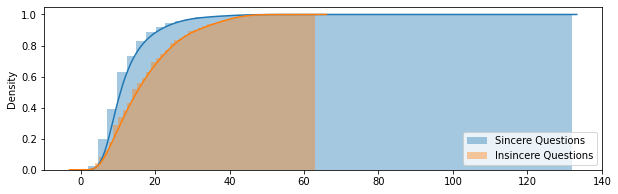

In [24]:
plt.figure(figsize=(10,3))
kwargs = {'cumulative': True}
sns.distplot(sincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Sincere Questions")
sns.distplot(insincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Insincere Questions")
plt.legend()
plt.show()

**SUMMARY:The CDF curve shows that at around 20 words, the probability of finding a sincere question is more compared to insincere question as they are supposed to have longer lengths as seen from previous plots.  We would see if the clean text with stopwords' distributions are similar to these plots or not.**

### Clean Text Distribution (Without Stopwords)

#### PDF

In [25]:
insincere_words = train_data[train_data['target']==1]['stemmed_text'].str.split().apply(len)
insincere_word_count = insincere_words.values

sincere_words = train_data[train_data['target']==0]['stemmed_text'].str.split().apply(len)
sincere_word_count = sincere_words.values

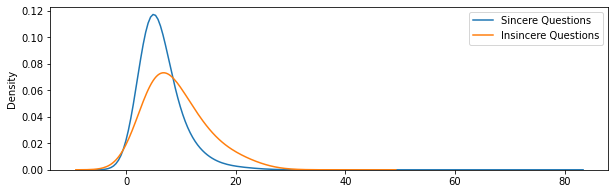

In [26]:
plt.figure(figsize=(10,3))
sns.kdeplot(sincere_word_count,label="Sincere Questions", bw=0.6)
sns.kdeplot(insincere_word_count,label="Insincere Questions", bw=0.6)
plt.legend()
plt.show()

#### CDF

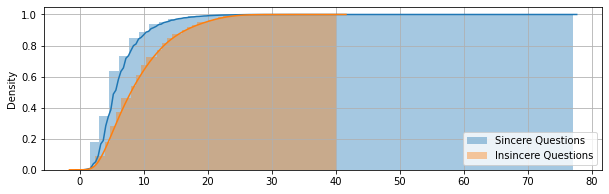

In [27]:
plt.figure(figsize=(10,3))
kwargs = {'cumulative': True}
sns.distplot(sincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Sincere Questions")
sns.distplot(insincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Insincere Questions")
plt.legend()
plt.grid()
plt.show()

**SUMMARY:These plots also show the similar distribution as distributions of question text. This shows that after cleaning, the size of sentences decreases thus consuming lesser memory but behaviour is still the same. We would also see the stopwords distribution just to check what is their distribution.**

### Stopwords Distribution

#### PDF

In [28]:
insincere_words = train_data[train_data['target']==1]['stopwords'].str.split().apply(len)
insincere_word_count = insincere_words.values
sincere_words = train_data[train_data['target']==0]['stopwords'].str.split().apply(len)
sincere_word_count = sincere_words.values

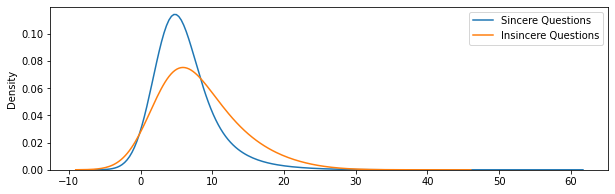

In [29]:
plt.figure(figsize=(10,3))
sns.kdeplot(sincere_word_count,label="Sincere Questions", bw=0.6)
sns.kdeplot(insincere_word_count,label="Insincere Questions", bw=0.6)
plt.legend()
plt.show()

#### CDF

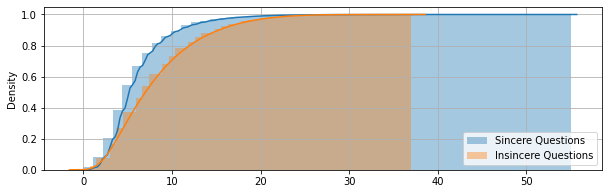

In [30]:
plt.figure(figsize=(10,3))
kwargs = {'cumulative': True}
sns.distplot(sincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Sincere Questions")
sns.distplot(insincere_word_count, hist_kws=kwargs, kde_kws=kwargs, label="Insincere Questions")
plt.legend()
plt.grid()
plt.show()

**SUMMARY:Stopwords also have the similar distribution, meaning that the stopwords are more in the insincere questions.**

# WordCloud (Clean Data)

## Insincere Questions

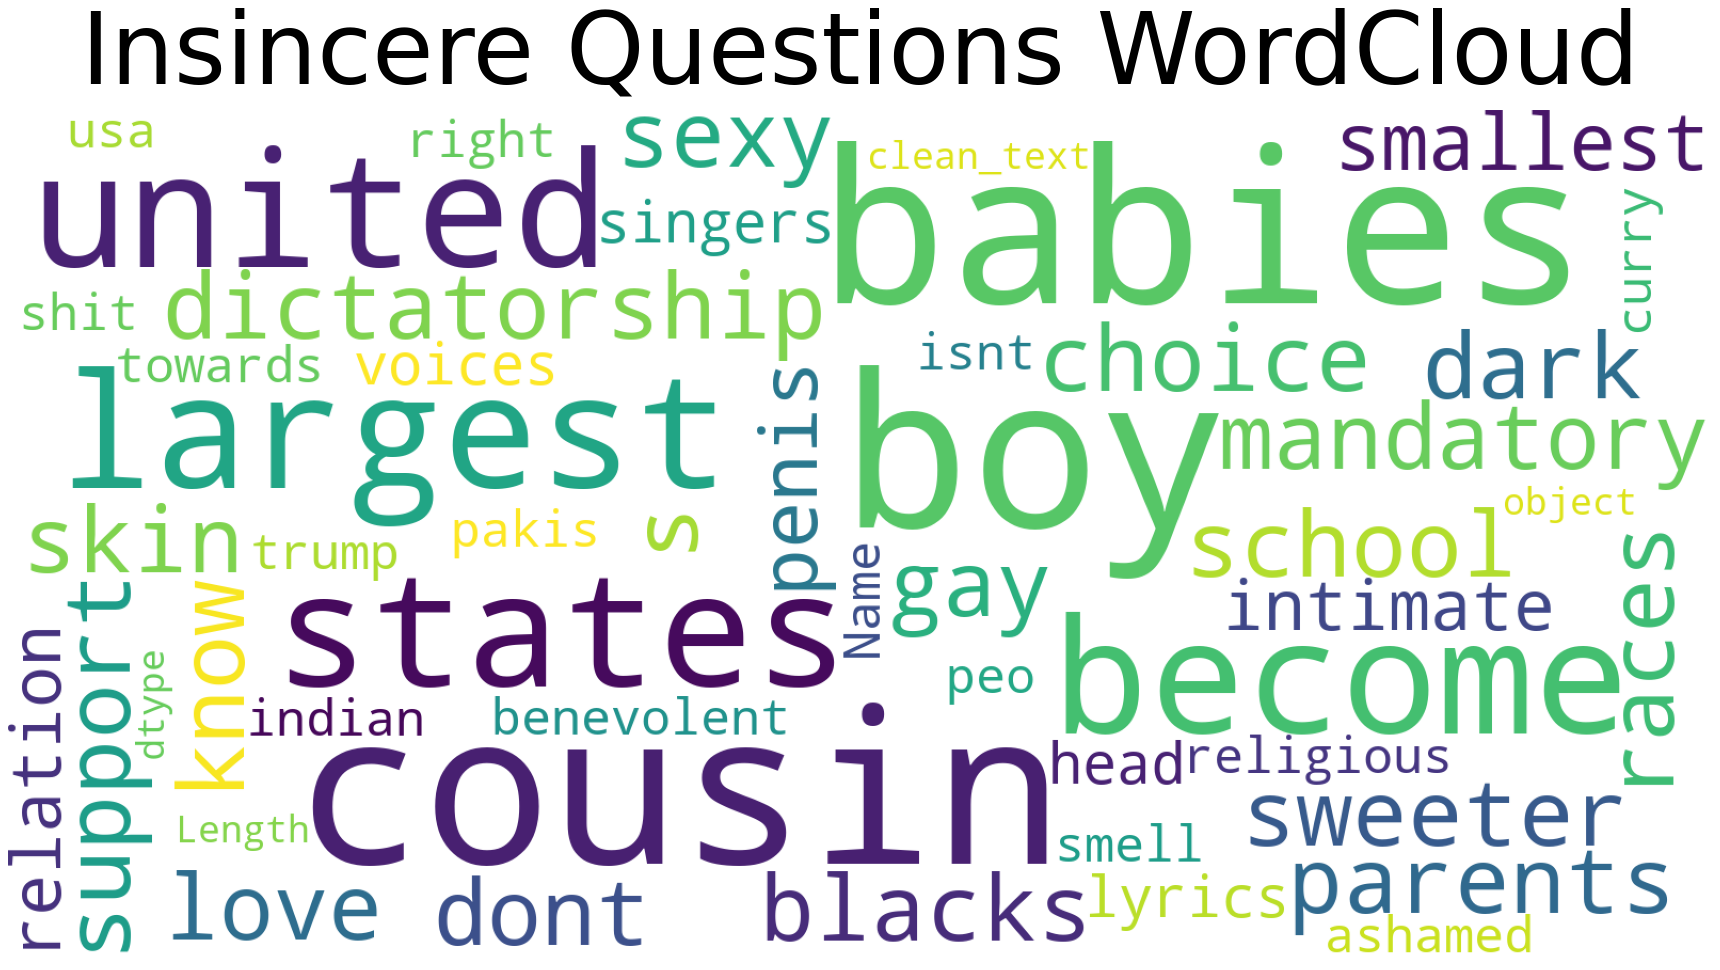

In [31]:
insincere_data = train_data[train_data['target']==1]['clean_text'].apply(lambda row: row.split(" "))
wordcloud = WordCloud(background_color='white',
                    max_words = 500,
                    max_font_size = 200, 
                    random_state = 42,
                    width=1600, 
                    height=800)
wordcloud.generate(str(insincere_data))
plt.figure(figsize=(24.0,16.0))

plt.imshow(wordcloud);
plt.title("Insincere Questions WordCloud", fontdict={'size': 100, 'color': 'black', 
                          'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()

## Sincere Questions

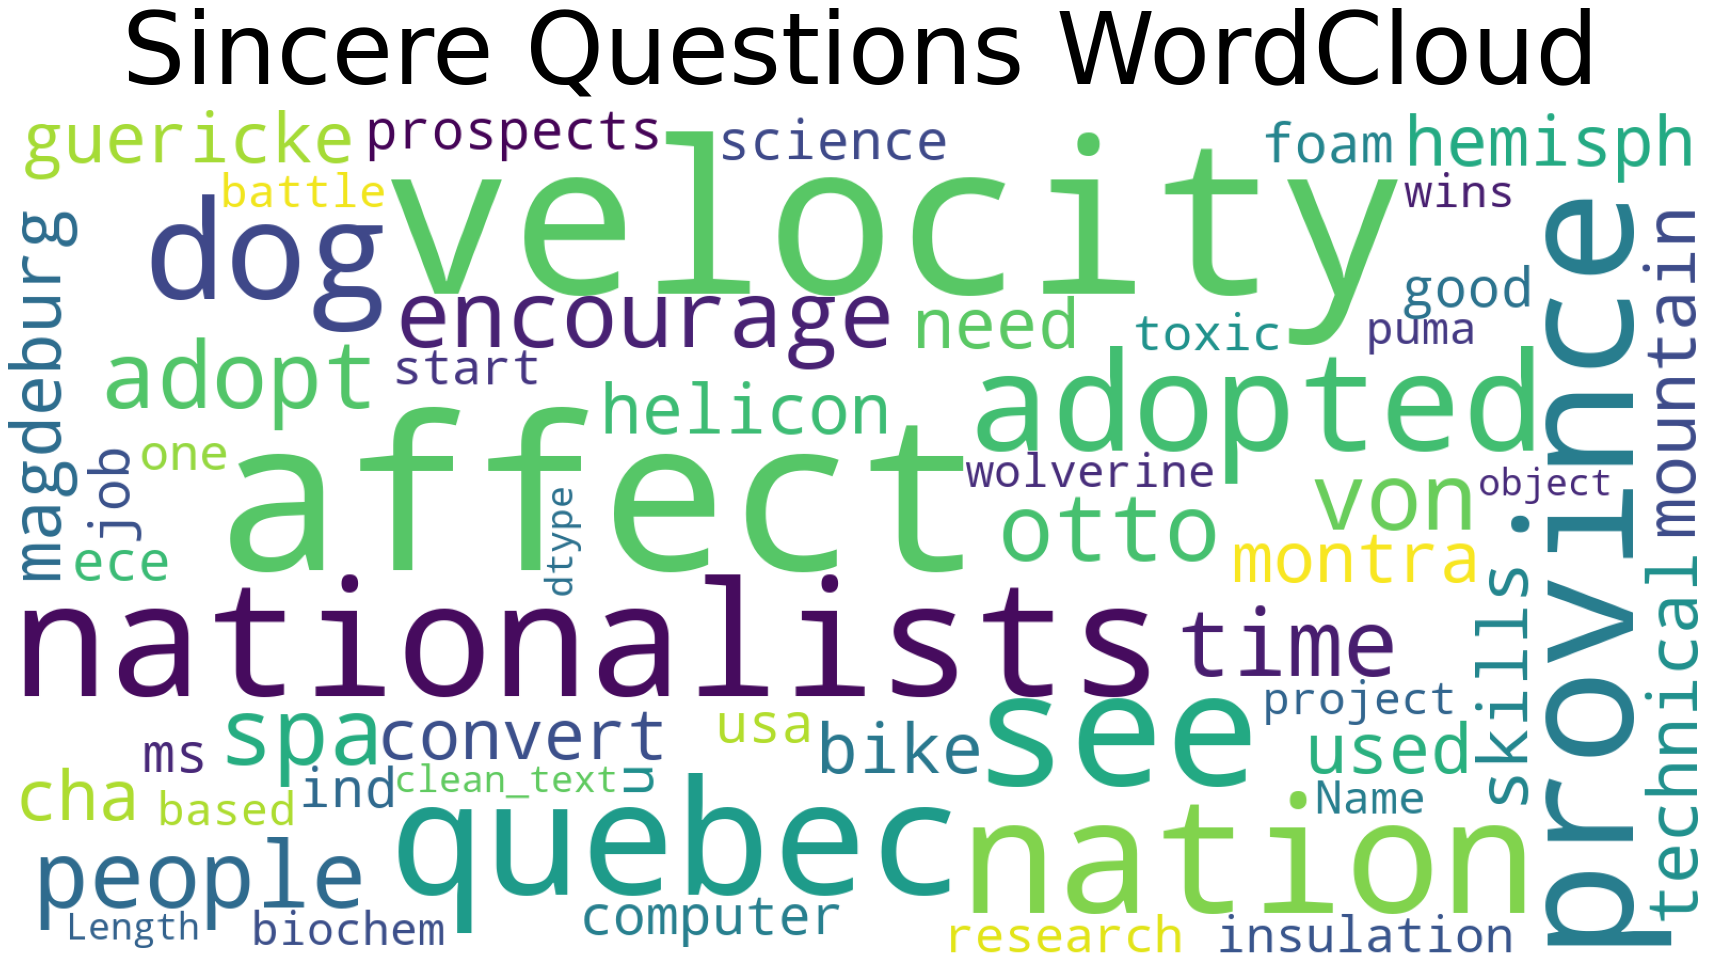

In [32]:
sincere_data = train_data[train_data['target']==0]['clean_text'].apply(lambda row: row.split(" "))
wordcloud = WordCloud(background_color='white',
                    max_words = 500,
                    max_font_size = 200, 
                    random_state = 42,
                    width=1600, 
                    height=800)
wordcloud.generate(str(sincere_data))
plt.figure(figsize=(24.0,16.0))

plt.imshow(wordcloud);
plt.title("Sincere Questions WordCloud", fontdict={'size': 100, 'color': 'black', 
                          'verticalalignment': 'bottom'})
plt.axis('off');
plt.tight_layout()

These wordclouds clearly show there are different popular words between insincere and sincere questions.

# Word Frequency Distribution (Clean Data)

## Insincere Questions

In [33]:
freq_dict = Counter()
for sent in insincere_data:
    for word in sent:
        freq_dict[word] += 1

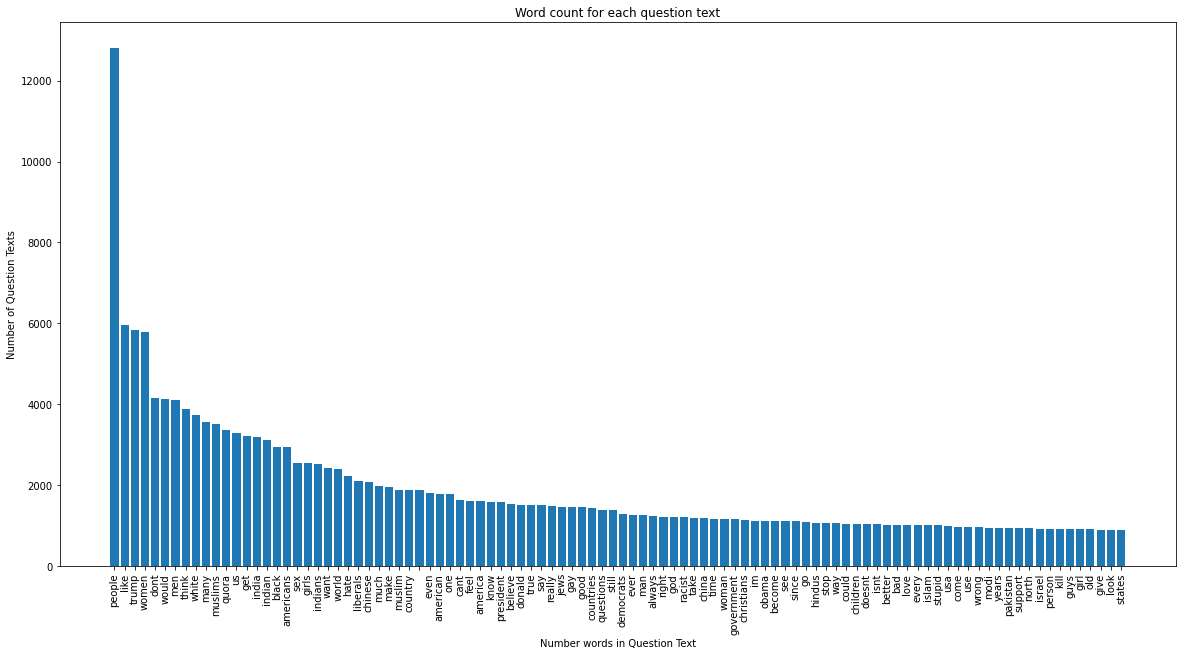

In [34]:
word_dict = dict(sorted(dict(freq_dict.most_common(100)).items(), key=lambda kv: kv[1], reverse=True))
ind = np.arange(len(word_dict))
plt.figure(figsize=(20,10))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Question Texts')
plt.xlabel('Number words in Question Text')
plt.title('Word count for each question text')
plt.xticks(ind, list(word_dict.keys()), rotation='vertical')
plt.show()

## Sincere Questions

In [35]:
freq_dict = Counter()
for sent in sincere_data:
    for word in sent:
        freq_dict[word] += 1

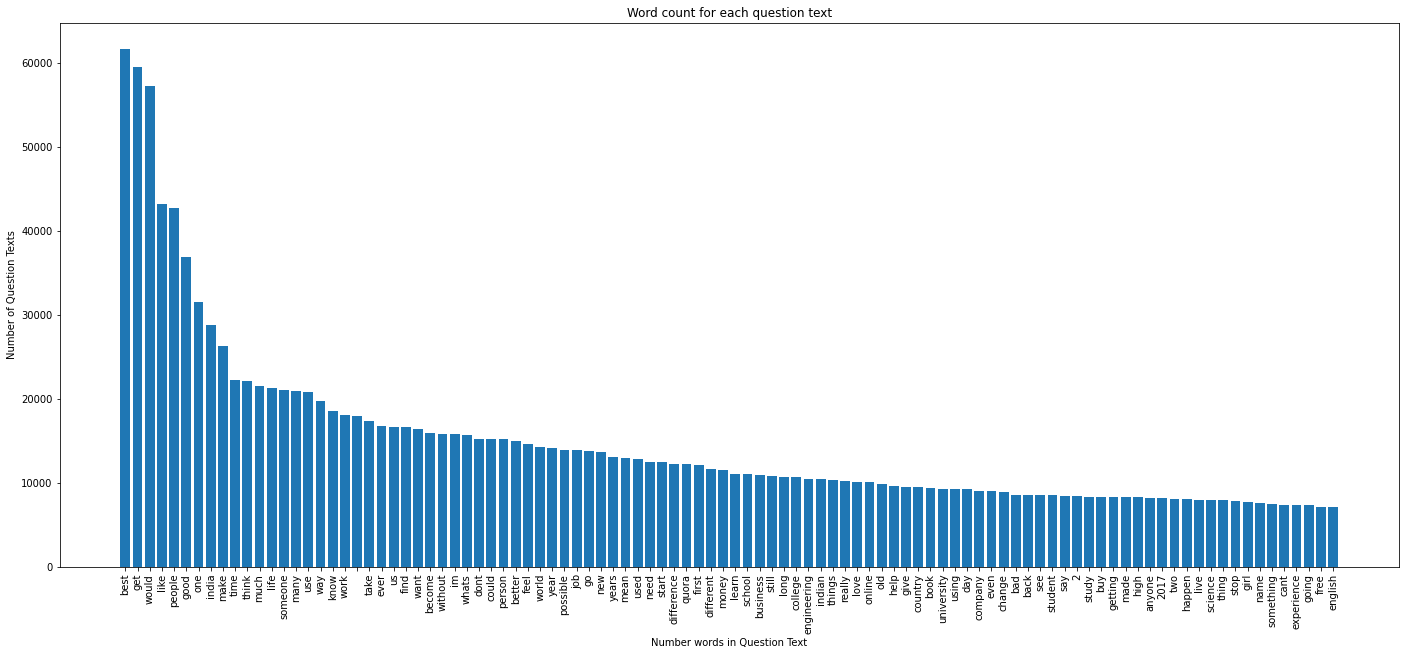

In [36]:
word_dict = dict(sorted(dict(freq_dict.most_common(100)).items(), key=lambda kv: kv[1], reverse=True))
ind = np.arange(len(word_dict))
plt.figure(figsize=(24,10))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Number of Question Texts')
plt.xlabel('Number words in Question Text')
plt.title('Word count for each question text')
plt.xticks(ind, list(word_dict.keys()), rotation='vertical')
plt.show()

### Observations:

- Some of the top words are common across both the classes like 'people', 'will', 'think' etc
- The other top words in sincere questions are 'best', 'good' etc. This means the sincere questions would be like "What is the best smartphone?"
- The other top words in insincere questions are 'trump', 'women', 'white', 'quora', 'muslims' etc. This means the insincere questions would be mostly propaganda-based, politically influenced or racist.


# Boxplot Distribution

### Question Text (With Stopwords)

In [37]:
train_data['num_words_text'] = train_data['question_text'].str.split().apply(len)
train_data['num_chars_text'] = train_data['question_text'].apply(lambda row: len(str(row)))

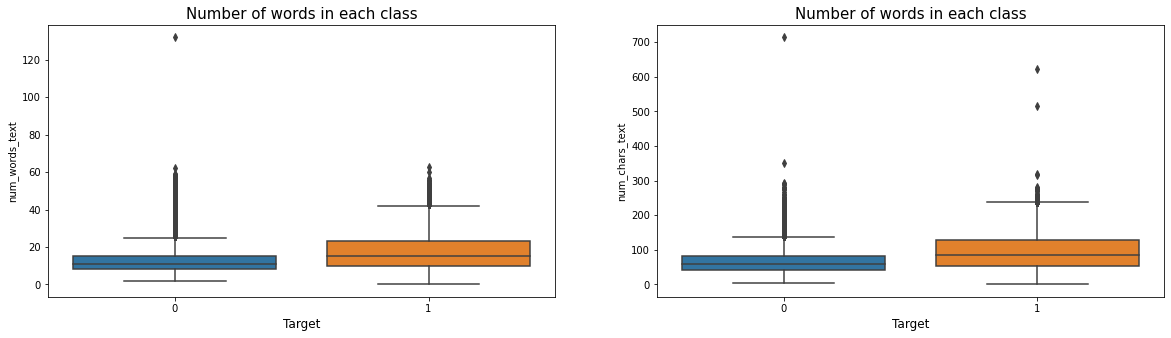

In [38]:
f, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x='target', y='num_words_text', data=train_data, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)
sns.boxplot(x='target', y='num_chars_text', data=train_data, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of words in each class", fontsize=15)
plt.show()

### Clean Text

In [39]:
train_data['num_words_clean'] = train_data['clean_text'].str.split().apply(len)
train_data['num_chars_clean'] = train_data['clean_text'].apply(lambda row: len(str(row)))

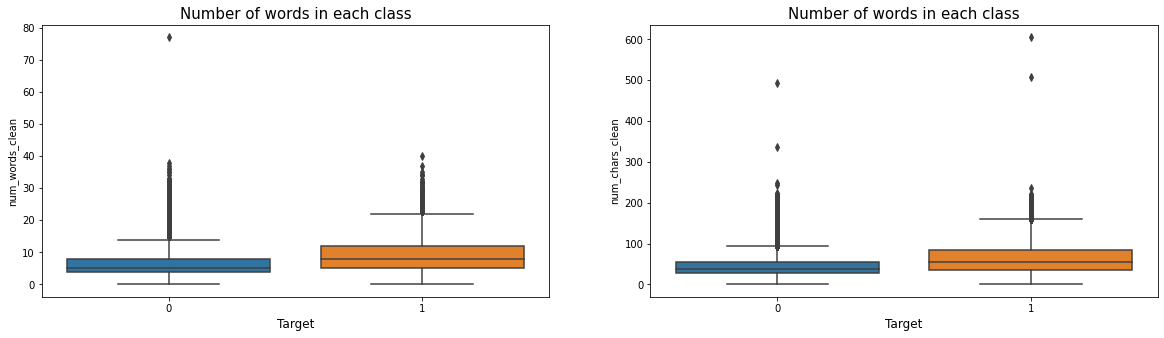

In [40]:
f, axes = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x='target', y='num_words_clean', data=train_data, ax=axes[0])
axes[0].set_xlabel('Target', fontsize=12)
axes[0].set_title("Number of words in each class", fontsize=15)
sns.boxplot(x='target', y='num_chars_clean', data=train_data, ax=axes[1])
axes[1].set_xlabel('Target', fontsize=12)
axes[1].set_title("Number of words in each class", fontsize=15)
plt.show()

We can see that the insincere questions have more number of words (both with or without stopwords) as well as characters compared to sincere questions. So this would help while building model.

# Classwize Text Embedding Visualization

## Bag of Words (BoW) and t-SNE over "question_text"

### Bag of Words (BoW)

In [41]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(train_data['question_text'])
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (1306122, 34871)


### Data Subset

In [42]:
text_bow_subset = text_bow[0:15000,:]
label_subset = train_data['target'][0: 15000]

### TSNE

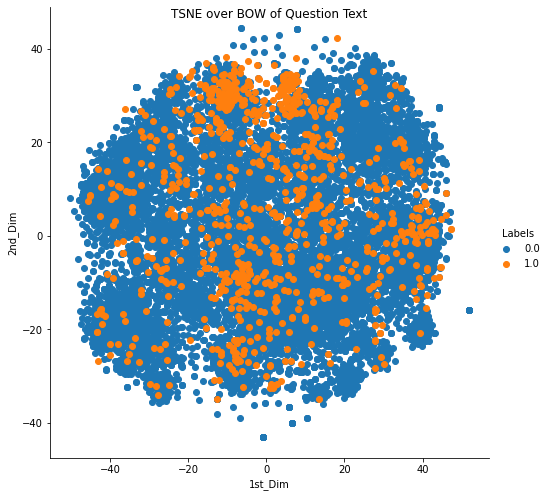

In [43]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 30.0, random_state = 0)
tsne_data_b = model.fit_transform(text_bow_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over BOW of Question Text")
plt.show()

Bag of Words (BoW) embeddings are distributed such that a clear boundary cannot be established.

# TF-IDF and t-SNE over "question_text"

### TF-IDF

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(train_data['question_text'])
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (1306122, 34871)


### Data Subset

In [45]:
text_tfidf_subset = text_tfidf[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

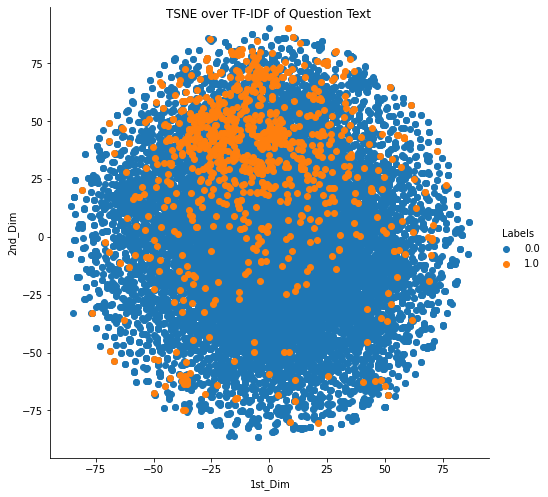

In [46]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 30.0, random_state = 0)
tsne_data_b = model.fit_transform(text_tfidf_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over TF-IDF of Question Text")
plt.show()

TF-IDF embeddings for insincere questions are mostly bunched together such that somewhat boundary can be established.

# Bag of Words (BoW) and t-SNE over "stemmed_text"

### Bag of Words (BoW)

In [47]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(train_data['stemmed_text'])
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (1306122, 24644)


### Dataset Subset

In [48]:
text_bow_subset = text_bow[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

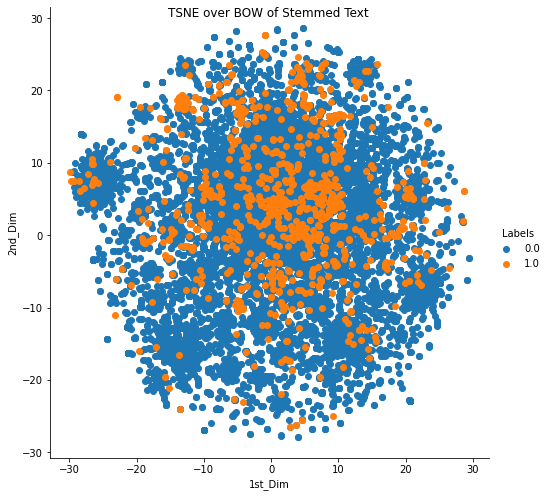

In [49]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 30.0, random_state = 0)
tsne_data_b = model.fit_transform(text_bow_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over BOW of Stemmed Text")
plt.show()

Bag of Words (BoW) embeddings are distributed such that a clear boundary cannot be established.

# TF-IDF and t-SNE over "stemmed_text"

### TF-IDF

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(train_data['stemmed_text'])
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (1306122, 24644)


### Dataset Subset

In [51]:
text_tfidf_subset = text_tfidf[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

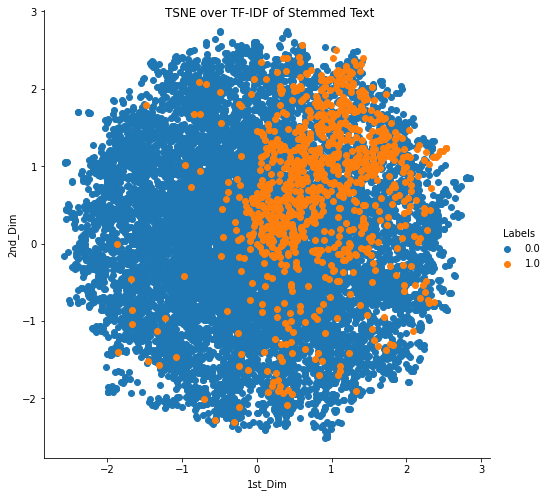

In [52]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 60.0, random_state = 0)
tsne_data_b = model.fit_transform(text_tfidf_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over TF-IDF of Stemmed Text")
plt.show()

TF-IDF embeddings for insincere questions are mostly bunched together such that a visible boundary can separate most of the data.

# Bag of Words (BoW) and t-SNE over "clean_text"

### Bag of Words (BoW)

In [53]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(train_data['clean_text'])
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (1306122, 34742)


### Dataset Subset

In [54]:
text_bow_subset = text_bow[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

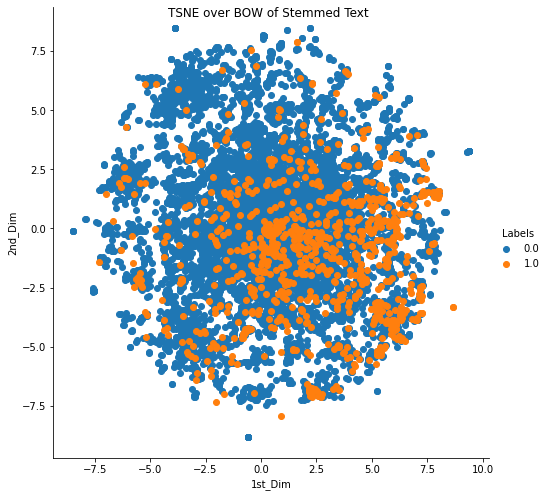

In [55]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 60.0, random_state = 0)
tsne_data_b = model.fit_transform(text_bow_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over BOW of Stemmed Text")
plt.show()

Bag of Words (BoW) embeddings are distributed such that a clear boundary cannot be established.

# TF-IDF and t-SNE over "clean_text"

### TF-IDF

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(train_data['clean_text'])
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (1306122, 34742)


### Dataset Subset

In [57]:
text_tfidf_subset = text_tfidf[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

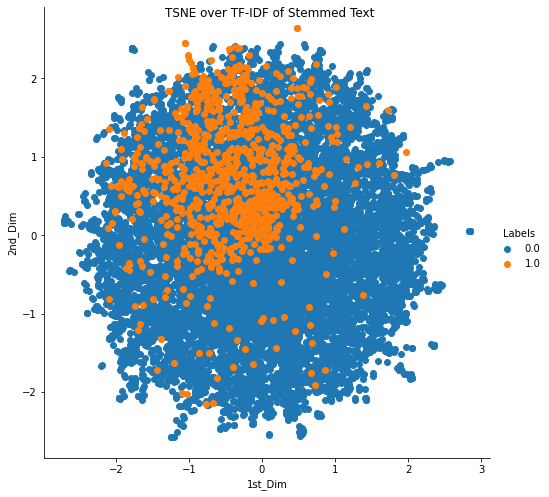

In [58]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 60.0, random_state = 0)
tsne_data_b = model.fit_transform(text_tfidf_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over TF-IDF of Stemmed Text")
plt.show()

TF-IDF embeddings for insincere questions are mostly bunched together such that a significant distinction can be established between classes.

# Bag of Words (BoW) and t-SNE over "lemmatized_text"

### Bag of Words (BoW)

In [59]:
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(train_data['lemmatized_text'])
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (1306122, 30436)


### Dataset Subset

In [60]:
text_bow_subset = text_bow[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

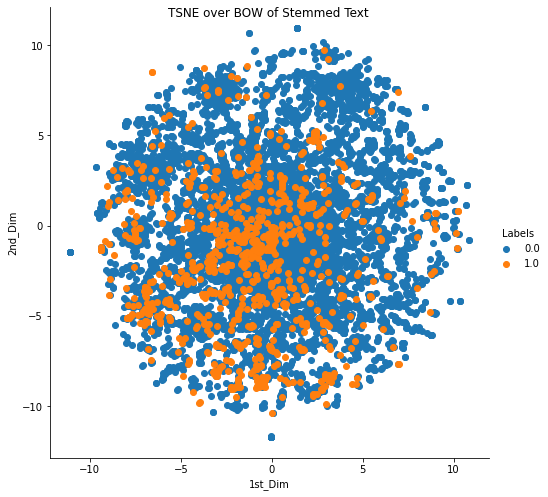

In [61]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 60.0, random_state = 0)
tsne_data_b = model.fit_transform(text_bow_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over BOW of Stemmed Text")
plt.show()

Bag of Words (BoW) embeddings are distributed such that a clear boundary cannot be established.

# TF-IDF and t-SNE over "lemmatized_text"

### TF-IDF

In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(train_data['lemmatized_text'])
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (1306122, 30436)


### Dataset Subset

In [63]:
text_tfidf_subset = text_tfidf[0:15000,:]
label_subset = train_data['target'][0: 15000]

### t-SNE

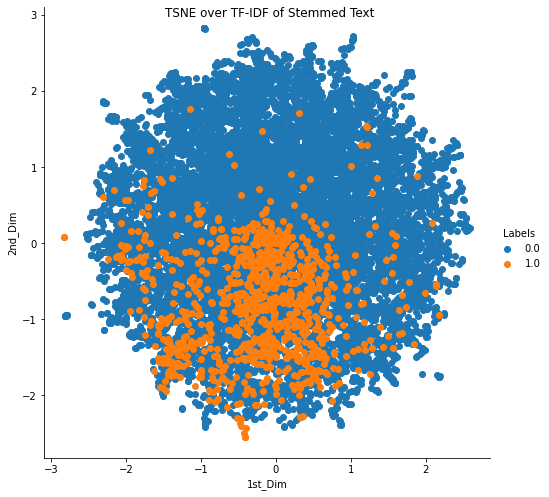

In [64]:
from sklearn.manifold import TSNE
model = TSNE(n_components = 2, perplexity = 60.0, random_state = 0)
tsne_data_b = model.fit_transform(text_tfidf_subset)
tsne_data_b = np.vstack((tsne_data_b.T, label_subset)).T
tsne_df_b = pd.DataFrame(tsne_data_b, columns = ("1st_Dim","2nd_Dim","Labels"))
sns.FacetGrid(tsne_df_b, hue = "Labels", height = 7).map(plt.scatter, "1st_Dim", "2nd_Dim").add_legend().fig.suptitle("TSNE over TF-IDF of Stemmed Text")
plt.show()

TF-IDF embeddings for insincere questions are mostly bunched together such that a significant distinction can be established between classes.

**SUMMARY: TF-IDF embeddings provide clearer boundaries between classes compared to Bag of Words (BoW).**